<a href="https://colab.research.google.com/github/Gaussiandra/NTA_Landmarks_Detection/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun  5 10:26:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Импорт библиотек

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-2swjd_89
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-2swjd_89
     |████████████████████████████████| 634kB 2.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=9e024c88df250fe22519f826145476d1ae33e8287880c255fb8e8aa0affc231c
  Stored in directory: /tmp/pip-ephem-wheel-cache-k3cekrss/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=fdb9fb95777540ca2cbef5a35013eab795776629ca48e763291c301f32575cd0
  Stored in directory: /tmp/pip-ephem-wheel-cache-k3cekrss/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
import os
import cv2
import gc
import time
import random
import pickle
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn import functional as fnn
from torchvision import transforms

## Параметры

In [0]:
NUM_PTS = 194
CROP_SIZE = 160
BATCH_SIZE = 64

In [0]:
SEED = 3462

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

global_path = '/content/drive/My Drive/ML/NTA Landmarks Detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TEST_PATH = global_path+"data/baseline_NTA/data/test/" 
TRAIN_PATH = global_path+"data/baseline_NTA/data/train/"
SUBMISSION_PATH = global_path+"data/baseline_NTA/data/train/"
LANDMARKS = global_path+"data/baseline_NTA/data/train/landmarks.csv"

SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

In [9]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.max_memory_allocated(device='cuda'))
print(torch.cuda.empty_cache())

1.5.0+cu101
10.1
7603
True
1
0
None


In [0]:
ignored_train_names = set({
    '110520830_5.jpg',
    '160565613_2.jpg',
    '171198578_1.jpg',
    '2071191303_1.jpg',
    '2076592686_3.jpg',
    '2202089258_1.jpg',
    '2106937488_1.jpg',
    '131787989_1.jpg',
    '11564757_1.jpg',
    '214426541_2.jpg',
    '2054916149_1.jpg',
    '2204494382_1.jpg',
    '2065218949_1.jpg',
    '171907511_1.jpg',
    '240281904_1.jpg',
    '2065219235_1.jpg',
    '2398691129_1.jpg',
    '2233737284_1.jpg',
    '2546411220_1.jpg',
 })

In [0]:
class LandmarksDataset(Dataset):
    def __init__(self, root, init_augmentations, split, train_augm=None, test_augm=None):
        assert split in ('train', 'test')

        super(LandmarksDataset, self).__init__()
        self.root = root
        self.init_augmentations = init_augmentations
        self.split = split
        self.train_augm = train_augm
        self.test_augm = test_augm

        file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
        images_root = os.path.join(root, "images")

        self.samples = []

        with open(file_name, "rt") as fp:
            for i, line in tqdm(enumerate(fp), total=len(os.listdir(images_root))):
                if i == 0:
                    continue  # skip header

                elements = line.strip().split(",")
                image_name = os.path.join(images_root, elements[0])
                cur_img = cv2.imread(image_name)
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

                if split == "train":
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                else:
                    landmarks = []

                augmented_data = init_augmentations(image=cur_img, keypoints=landmarks)
                cur_sample = {
                    'x_init_resolution': cur_img.shape[1],
                    'y_init_resolution': cur_img.shape[0],
                    'image': augmented_data['image'],
                    'keypoints': augmented_data['keypoints'],
                    'img_name': elements[0]
                }

                self.samples.append(cur_sample)

    def get_box(self, keypoints, bound=40):
        x_min = int(round(min(map(lambda x: x[0], keypoints))))
        x_max = int(round(max(map(lambda x: x[0], keypoints))))
        y_min = int(round(min(map(lambda x: x[1], keypoints))))
        y_max = int(round(max(map(lambda x: x[1], keypoints))))

        return (
            max(0, x_min-bound),
            max(0, y_min-bound),
            min(2*CROP_SIZE, x_max+bound),
            min(2*CROP_SIZE, y_max+bound)
        )
    
    def __getitem__(self, idx):
        cur_sample = dict(self.samples[idx])

        if self.split == 'train':
            if cur_sample['img_name'] in ignored_train_names:
                cur_sample = dict(np.random.choice(self.samples))

            augmented_data = self.train_augm(
                cropping_bbox=self.get_box(cur_sample['keypoints']),
                **cur_sample
            )
            
            cur_sample['image'] = augmented_data['image']
            cur_sample['keypoints'] = np.array(augmented_data['keypoints'])
            return cur_sample
        else:
            return self.test_augm(**cur_sample)

    def __len__(self):
        return len(self.samples)

In [0]:
# Корректный флип точек нагло скопирован из ods
# https://opendatascience.slack.com/archives/CGHGA0DQC/p1591103022218100?thread_ts=1591101465.217800&cid=CGHGA0DQC

keypoint_reflection_indexes = [
    [slice(0, 21), slice(40, 19, -1)],
    [slice(41, 50), slice(57, 48, -1)],
    [slice(58, 65), slice(71, 64, -1)],
    [slice(72, 79), slice(85, 78, -1)],
    [slice(86, 93), slice(99, 92, -1)],
    [slice(100, 107), slice(113, 106, -1)],
    [slice(114, 134), slice(134, 154)],
    [slice(154, 174), slice(174, 194)]
]

def reflect_keypoints(keypoints):
    new_keypoints = deepcopy(keypoints)
    for slice1, slice2 in keypoint_reflection_indexes:
        new_keypoints[slice1] = keypoints[slice2]
        new_keypoints[slice2] = keypoints[slice1]
    return new_keypoints

class CustomHorizontalFlip(albu.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints = reflect_keypoints(keypoints)
        return super().apply_to_keypoints(keypoints, **params)

class CustomCoarseDropout(albu.CoarseDropout):
    def apply(self, image, fill_value=0, holes=(), **params):
        return albu.augmentations.functional.cutout(image, holes, image.mean())

init_augm = albu.Compose([
    albu.LongestMaxSize(2*CROP_SIZE),
    albu.PadIfNeeded(2*CROP_SIZE, 2*CROP_SIZE, 1),                  
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

train_augm = albu.Compose([
    albu.RandomCropNearBBox(0.07, p=0.5),
    albu.IAAPerspective((0.07, 0.07), p=1),
    albu.Rotate(30, p=0.5),
    albu.Resize(CROP_SIZE, CROP_SIZE),
    CustomHorizontalFlip(p=0.5),

    albu.RGBShift(0.02, 0.02, 0.02, p=0.5),
    albu.HueSaturationValue(10, 20, 10, p=0.5),
    albu.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    albu.CLAHE(2, p=0.5),
    albu.IAAEmboss(p=0.5),
    albu.MedianBlur(4, p=0.5),
    albu.ToGray(p=0.15),
    albu.IAASharpen(p=0.5),
    albu.ISONoise(p=0.5),
    albu.ImageCompression(90, p=0.33),
    CustomCoarseDropout(120, 6, 6, min_holes=40, p=0.5),

    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

test_augm = albu.Compose([
    albu.Resize(CROP_SIZE, CROP_SIZE),
    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

In [0]:
#whole_dataset = LandmarksDataset(os.path.join(TRAIN_PATH), init_augm, "train", train_augm=train_augm)
#test_dataset = LandmarksDataset(os.path.join(TEST_PATH), init_augm, "test", test_augm=test_augm)
#pickle.dump(whole_dataset, open(global_path+'whole_ds.pkl', 'wb'))
#pickle.dump(test_dataset, open(global_path+'test_ds.pkl', 'wb'))

In [0]:
whole_dataset = pickle.load(open(global_path+'whole_ds.pkl', 'rb'))
test_dataset = pickle.load(open(global_path+'test_ds.pkl', 'rb'))

In [0]:
whole_dataset.train_augm = train_augm
test_dataset.test_augm = test_augm

In [0]:
def vis_points(image, points, diameter=15):
    im = image.copy()
    
    for i, (x, y) in enumerate(points):
        cv2.circle(im, (int(x), int(y)), diameter, (255, 0, 0), -1)

    plt.figure(figsize=(6, 6))
    plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

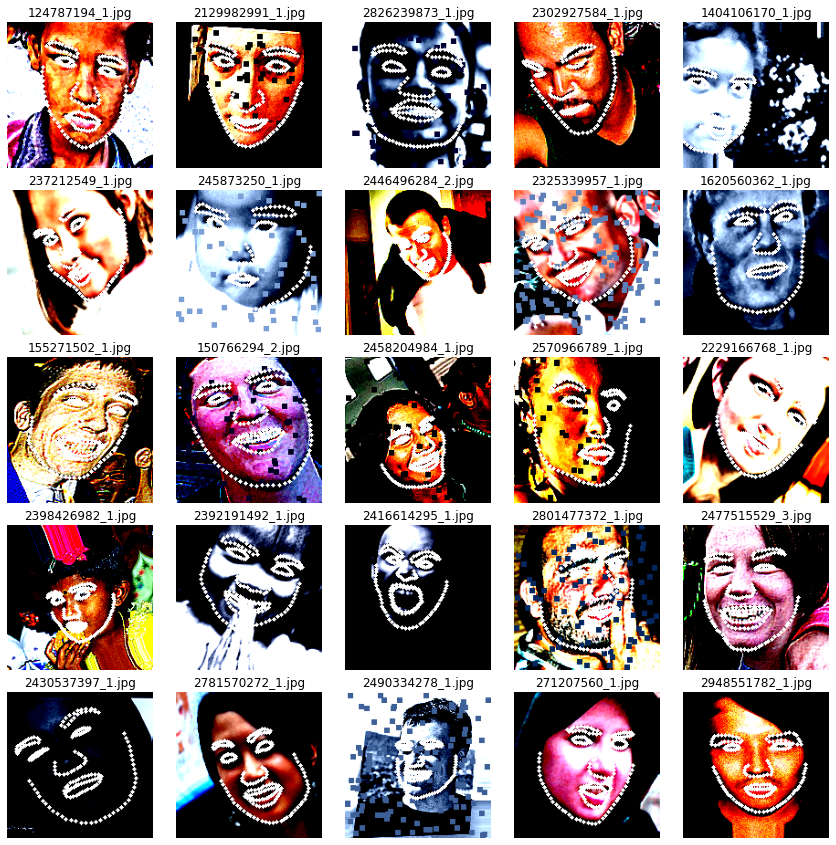

In [15]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.05, hspace=0.15)

for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.axis('off')

    augm_img = whole_dataset[np.random.randint(0, 2001)]
    im = augm_img['image'].copy()  

    for x, y in augm_img['keypoints']:
        cv2.circle(im, (int(x), int(y)), 2, (255, 255, 255), -1)

    plt.title(augm_img['img_name'])
    plt.imshow(im)

In [0]:
torch.manual_seed(SEED)

from torch.utils.data import random_split
train_size = int(0.9 * len(whole_dataset))
val_size = len(whole_dataset) - train_size
train_dataset, val_dataset = random_split(whole_dataset, [train_size, val_size])

In [0]:
#######
train_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [0]:
gc.collect()

866

In [18]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [0]:
from facenet_pytorch import InceptionResnetV1
vggface2 = InceptionResnetV1(num_classes=1)#pretrained='vggface2')

In [0]:
model = nn.Sequential(
    nn.Sequential(*list(vggface2.children())[:-4]),
    nn.Conv2d(1792, 2*NUM_PTS, 1),
    nn.MaxPool2d(1, 1),
    nn.Flatten(),
    #nn.BatchNorm1d(2*NUM_PTS),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
loss_fn = fnn.mse_loss

cur_iter = 0

In [0]:
# Другой facenet, больше аугментаций, нормальная архитектура, статеечки, лайфхаки по аугментациям
# Последняя сввёртка -- выкинуть или заменить нормальными
# GAN augment
# catboost поверх 
# Работа с фото с самыми высокими ошибками, hard negatives mining?
# Клиппинг предсказанны координат
# Усреднять значения для теста на аугментации
# Усреднять веса с лучших точек
# погуглить про pseudolabeling
# Отлючить обучение у сверток?

In [0]:
#!rm -rf '/content/drive/My Drive/ML/TG_DL/10/tensorboard/'

In [0]:
model_name = 'vggface2_cut-4 full ds + new_augment'

In [23]:
last_checkpoint = torch.load(
    global_path+'vggface2_cut-4 full ds + new_augment_29_whole ds.tar',
    map_location=device
)

model.load_state_dict(last_checkpoint['model'])
optimizer.load_state_dict(last_checkpoint['optim'])
cur_iter = last_checkpoint['n_iters']

cur_iter, last_checkpoint['n_iters']

(29, 29)

In [0]:
import tensorflow as tf
%load_ext tensorboard

In [0]:
tb_path = global_path+'tensorboard/'
train_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_train')
val_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_val')

In [188]:
%tensorboard --logdir '/content/drive/My Drive/ML/NTA Landmarks Detection/tensorboard/'

Reusing TensorBoard on port 6006 (pid 8407), started 0:07:29 ago. (Use '!kill 8407' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
clown_names = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


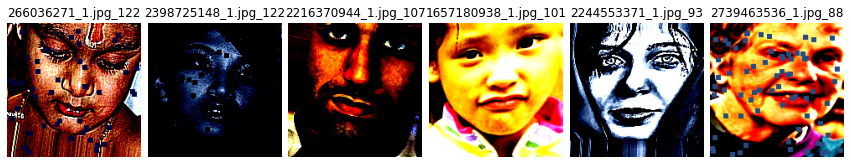

In [187]:
MINE_HARD_NEGOTIVES = False
for e in range(1):
    hard_losses, hard_images, hard_landmarks = [torch.tensor([], device=device)] * 3
    hard_names = np.array([])
    for batch in tqdm(train_iter, desc=str(f'{e}_{cur_iter}')):
        model.train()
        optimizer.zero_grad()
        whole_dataset.train_augm = train_augm

        images = batch['image'].permute([0, 3, 1, 2]).to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)  # B x (2 * NUM_PTS)

        pred_landmarks = model(images)  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction='none')

        hard_indecies = loss.mean(dim=1).argsort(descending=True)[:4]
        hard_losses = torch.cat([hard_losses, loss[hard_indecies].mean(dim=1)])
        hard_names = np.hstack((hard_names, np.array(batch['img_name'])[hard_indecies.cpu()]))
        hard_images = torch.cat([hard_images, images[hard_indecies]])
        hard_landmarks = torch.cat([hard_landmarks, landmarks[hard_indecies]])

        loss.mean().backward()
        optimizer.step()
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.mean().item(), step=cur_iter)

        if cur_iter % 10 == 0:
            model.eval()
            whole_dataset.train_augm = test_augm

            batch = next(iter(val_iter))
            images = batch['image'].permute([0, 3, 1, 2]).to(device)
            landmarks =  batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

            with torch.no_grad():
                pred_landmarks = model(images)
            loss = loss_fn(pred_landmarks, landmarks)

            with val_summary_writer.as_default():
                tf.summary.scalar('loss', loss.item(), step=cur_iter)

        cur_iter += 1
    
    if MINE_HARD_NEGOTIVES:
        loss = loss_fn(model(hard_images), hard_landmarks)
        loss.backward()
        optimizer.step()

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.item(), step=cur_iter+1)
        cur_iter += 1

    hard_indecies = hard_losses.argsort(descending=True)[:6]
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for i, idx in enumerate(hard_indecies, 1):
        if hard_losses[idx].item() > 200:
            clown_names.append(hard_names[idx])

        plt.subplot(1, 6, i)
        plt.axis('off')
        plt.title(f'{hard_names[idx]}_{round(hard_losses[idx].item())}')
        plt.imshow(np.array(hard_images[idx].permute([1, 2, 0]).cpu()))
    plt.show()

In [189]:
save_path = f'{global_path}{model_name}_{cur_iter}_whole ds.tar'
assert not os.path.exists(save_path)
torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'n_iters': cur_iter
        }, save_path)      

print(save_path)

/content/drive/My Drive/ML/NTA Landmarks Detection/vggface2_cut-4 full ds + new_augment_4136_whole ds.tar


In [190]:
set_of_clowns = set(clown_names) - ignored_train_names
set_of_clowns

{'1408008592_1.jpg',
 '1657180938_1.jpg',
 '190546275_1.jpg',
 '2546411220_1.jpg',
 '2942017513_1.jpg'}

1657180938_1.jpg


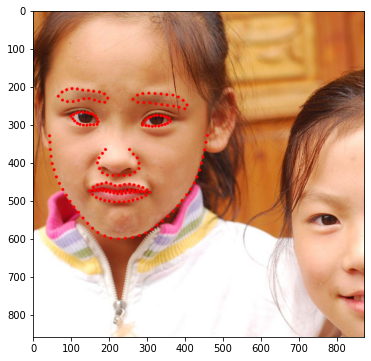

2546411220_1.jpg


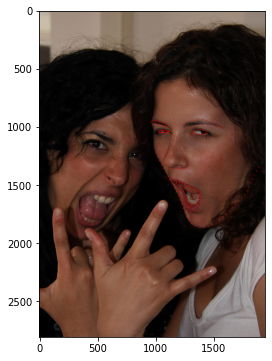

190546275_1.jpg


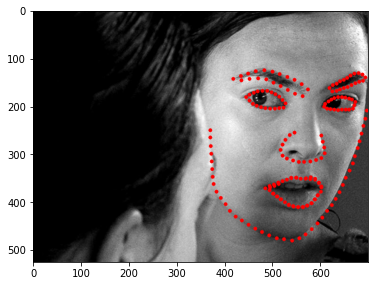

1408008592_1.jpg


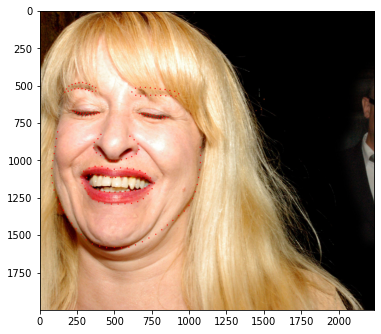

2942017513_1.jpg


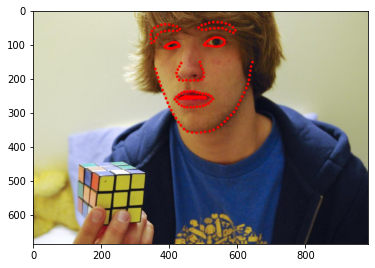

In [191]:
landmark_csv = pd.read_csv(os.path.join(TRAIN_PATH, 'landmarks.csv'), index_col='filename')

chf = albu.Compose([
    albu.NoOp()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

images_root = os.path.join(TRAIN_PATH, "images")

for image_name in set_of_clowns:
    print(image_name)

    cur_img = cv2.imread(os.path.join(images_root, image_name))
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

    landmarks = list(map(np.int16, landmark_csv.loc[image_name].values))
    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))

    augm_img = chf(image=cur_img, keypoints=landmarks)
    vis_points(augm_img['image'], augm_img['keypoints'], diameter=4)
    plt.show()

In [196]:
losses = []
whole_dataset.train_augm = test_augm
val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
model.eval()

for batch in val_iter:
    images = batch['image'].permute([0, 3, 1, 2]).to(device)
    landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
    losses.append(loss.item())
    
np.mean(losses), np.std(losses)

(4.074511170387268, 0.6811373003828417)

In [0]:
def shift_augm_landmark(init_resolution, landmarks):
    points = torch.tensor(landmarks) 

    scale_factor = max(init_resolution) / CROP_SIZE
    x_margin = (CROP_SIZE - init_resolution[0] / scale_factor) / 2
    y_margin = (CROP_SIZE - init_resolution[1] / scale_factor) / 2
    margin_pair = np.array([x_margin, y_margin])

    handle_pair = lambda x: (x - margin_pair) * scale_factor
    return list(map(handle_pair, points))
    
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    
    cur_str = 0
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch['image'].permute([0, 3, 1, 2]).to(device) 

        with torch.no_grad():
            pred_landmarks = model(images).cpu().numpy()  # B x NUM_PTS x 2

        for j in range(len(batch['x_init_resolution'])):
            hz = shift_augm_landmark((batch['x_init_resolution'][j], batch['y_init_resolution'][j]), pred_landmarks[j].reshape(NUM_PTS, 2))
            hz = np.array(list(map(lambda x: np.array(x), hz)))

            predictions[cur_str] = hz
            cur_str += 1

    return predictions

def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data)

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter=',')
    
    for i, row in mapping.iterrows():   
        file_name = row[0]

        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [197]:
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_predictions = predict(model, test_iter, device)

In [0]:
create_submission(TEST_PATH, test_predictions, "submit.csv")

---

In [0]:
def get_orig_img(path, split, index):
    root = path
    file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
    images_root = os.path.join(root, "images")

    with open(file_name, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            image_name = os.path.join(images_root, elements[0])
            cur_img = cv2.imread(image_name)
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

            return cur_img

def coords_from_sumb_file(path, index):
    with open(path, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            return np.array(list(map(int, elements[1:])))
            
def landmarks2pairs(points):
    x_coords = np.array(points[::2], dtype=np.uint8)
    y_coords = np.array(points[1::2], dtype=np.uint8)

    return list(zip(x_coords, y_coords))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


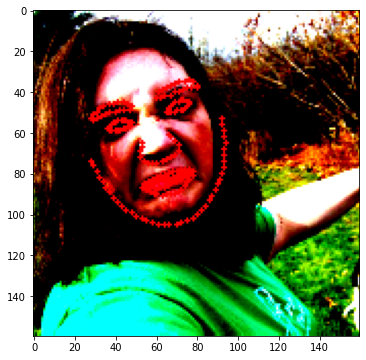

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


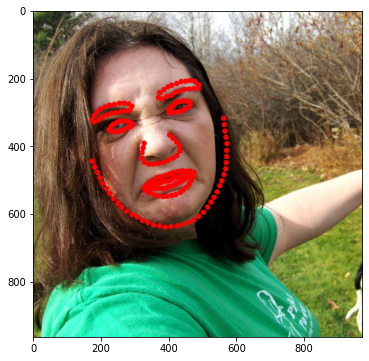

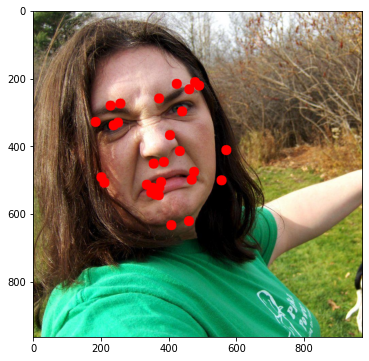

In [207]:
cur_img, cur_predictions, id = 0, 0, np.random.randint(64)

model.eval()
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
for i, data in enumerate(test_iter):
    cur_img = data['image'].permute([0, 3, 1, 2])[id].unsqueeze(dim=0).to(device)
    cur_predictions = model(cur_img).cpu().detach()
    break

vis_points(test_dataset[id]['image'], landmarks2pairs(cur_predictions[0]), diameter=1)
plt.show()

cur_orig_img = get_orig_img(TEST_PATH, 'test', id)
shifted_preds = shift_augm_landmark((test_dataset[id]['x_init_resolution'], test_dataset[id]['y_init_resolution']), cur_predictions[0].reshape(194, 2))
vis_points(cur_orig_img, shifted_preds, 8)
plt.show()

vis_points(cur_orig_img, coords_from_sumb_file("submit.csv", id).reshape(-1, 2))

---